# 데이터 로드 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from glob import glob 
import os 
from typing import Sequence, Tuple

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/MyDrive/공유용/train_features.tar'

In [ ]:
folder_dir = glob('/content/*')
folder_dir = folder_dir[:-1]

In [ ]:
dir = {} #공항별  디렉토리 모음 
for folder in folder_dir:
  csvs_dir = glob(folder+'/*.bz2')
  csvs_dir = pd.DataFrame(csvs_dir,columns=['dir'])
  dir[folder.split('/')[-1]] = csvs_dir
airport_names = list(dir.keys())
airport_names.remove('drive')

In [ ]:
#원하는 파일의 디렉토리를 디렉토리 df에서 가져 옴 
def make_dir(dir,df):
  csv_dir = df[df['dir'].apply(lambda x : dir in x )].values[0][0]
  return csv_dir 

In [ ]:
# # Airport config 이외 다른 df 가져올 때 
# csvs_name = list(csvs_dir['dir'].apply(lambda x : x.split('katl/')[-1].split('.csv')[0].split('_',maxsplit=1)[-1]))
# for csv_name in tqdm(csvs_name):
#   exec(f"{csv_name} = pd.read_csv(make_dir('{csv_name}',csvs_dir))")

Config, Lamp 데이터 로드 

In [ ]:
lamp_df = {} #공항 별 lamp 데이터 딕셔너리 
config_df = {} #공항 별 Configuration 데이터 딕셔너리 
for airport in airport_names:
  temp_lamp = make_dir('lamp',dir[airport])
  lamp_df[airport] = pd.read_csv(temp_lamp) 
  temp_csv = pd.read_csv(make_dir('config',dir[airport]))
  config_df[airport] = temp_csv

# 데이터 전처리 

## 30분 단위 분할 

In [ ]:
#입력한 시간 대로 분할 
def split_config_min(split_df,split_min):
  split_df['timestamp'] = pd.to_datetime(split_df['timestamp'])
  split_df = split_df.sort_values(by='timestamp')
  split_df = pd.DataFrame(split_df.set_index('timestamp').airport_config.resample(split_min).ffill().dropna()).reset_index()
  return split_df

In [ ]:
#모든 항공사 30분 단위로 분할 
for airport in airport_names:
  config_df[airport] = split_config_min(config_df[airport],'30min')
  

In [ ]:
temp_df = lamp_df[airport]
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
temp_df = temp_df.sort_values(by=['timestamp','forecast_timestamp'])
temp_df = temp_df.reset_index().drop(columns='index')

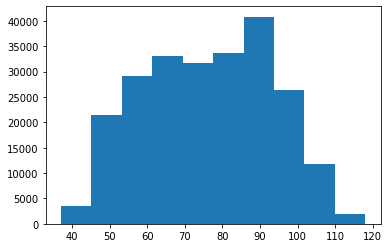

In [ ]:
plt.hist(temp_df['temperature'])
plt.show()

## One hot Encoding 

In [ ]:
def one_hot(config,label):
  if config == label:
    return 1 
  else:
    return 0

In [ ]:
open_train_label = pd.read_csv('/content/drive/MyDrive/공유용/open_train_labels (1).csv.bz2')

In [ ]:
#각 항공 별 label one hot encoding 
for airport in tqdm(airport_names):
  airport_config = config_df[airport]

  labels = pd.get_dummies(open_train_label[open_train_label['airport']==airport],columns=['config']).columns[4:]
  labels = list(pd.Series(labels).apply(lambda x : x.split(':')[-1]))

  for label in labels:
    airport_config[label]='-'
    airport_config[label] = airport_config['airport_config'].apply(lambda x: one_hot(x,label))
  config_df[airport] = airport_config

100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


In [ ]:
for airport in airport_names:
  print(len(config_df[airport].columns))

14
33
40
16
29
33
30
20
15
44


# 제너레이터 

## 사전설정

In [ ]:
#기준 timestamp에서 과거 6시간 동안의 데이터를 호출 함 
def past_censor_data(
    airport_config_df: pd.DataFrame, std_timestamp: pd.Timestamp) -> Tuple[str, pd.DataFrame]:
    mask = airport_config_df["timestamp"] < std_timestamp
    subset = airport_config_df[mask][-12:] #6시간만 자르기 
    subset = np.array(subset.drop(columns = ['timestamp','airport_config']))
    return subset

#기준 timestamp에서 미래 6시간 동안의 데이터를 호출 함 
def future_censor_data(airport_config_df: pd.DataFrame, std_timestamp: pd.Timestamp):
    mask = airport_config_df["timestamp"] > std_timestamp
    subset = airport_config_df[mask][:12] #6시간만 자르기 
    subset = np.array(subset.drop(columns = ['timestamp','airport_config']))
    return subset

#기준 timestamps (input-output 연결 키 )
def make_timestamps(airport_config):
  airport_config = airport_config.sort_values(by='timestamp')
  timestamps = list(airport_config['timestamp'])[12:-12]
  return timestamps

In [ ]:
#batch 대로 future or past 가져오는 것 
def batch_censor_data(airport_config,batch_timestamps,mode):
  shape = len(airport_config.columns[2:])
  return_config = np.arange(len(batch_timestamps)*12*shape).reshape(-1,12,shape)
  if mode =='past':    
    for n,batch_timestamp in enumerate(batch_timestamps):
      temp_config = past_censor_data(airport_config,batch_timestamp)
      return_config[n,:,:] = temp_config
    return return_config
  if mode == 'future':
    for n,batch_timestamp in enumerate(batch_timestamps):
      temp_config = future_censor_data(airport_config,batch_timestamp)
      return_config[n,:,:] = temp_config
    return return_config

## 제너레이터 

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
  def __init__(self,
                 airport_config,
                 timestamps,
                 batch_size: int):
        self.airport_config = airport_config
        self.timestamps = timestamps
        self.batch_size = batch_size
        
  def __len__(self):
    return math.ceil(len(self.timestamps) / self.batch_size)
    
  def __getitem__(self, index):
    self.batch_timestamps = self.timestamps[index*self.batch_size:(index+1)*self.batch_size]
    #past data 
    past_configs = batch_censor_data(self.airport_config,self.batch_timestamps,'past')

    #future data 
    future_configs = batch_censor_data(self.airport_config,self.batch_timestamps,'future')

    return np.array(past_configs), np.array(future_configs)

In [ ]:
i=0
BATCH_SIZE = 64
airport = airport_names[i]
airport_config = config_df[airport]
timestamps = make_timestamps(airport_config)

train_generator = DataGenerator(airport_config,timestamps,BATCH_SIZE)
in_con, out_con = next(iter(train_generator))
print(in_con.shape,out_con.shape)

(64, 12, 12) (64, 12, 12)


#모델
**softmax 방식**
- 과거 6시간의 airport configuration 정보를  이용해 미래의 30분 이후 ~ 6시간 이후를 예측 
- ex : 11시에 예측을 시행한다 할 경우 11시 이전의 6시간(5~11시)까지의 데이터를 이용해 11시30분, 12시 ~ 17시 까지의 데이터들을 예측 
- 예측 하는 방식은 one hot encoding 형태의 configuration을 softmax로 확률 예측 
- 분류에선 softmax score로 분류를 했지만 여기서는 softmax score를 확률로써 그대로 사용 

**Regression 방식** <- 우선 regression 으로 진행 
- 과거의 6시간 데이터를 이용해 미래의 6시간을 통으로 예측 
- input : 과거 6시간 데이터 -> output : 미래 6시간  
- regression을 통해 나온 결과들을 min,max scaling을 통해 sum 1로 맞춰줌 

##사전설정

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization,Input,Dropout,Dense,Conv2D,Concatenate,Flatten,Conv1D,Conv2D
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D,GlobalAveragePooling3D,AveragePooling3D

##콜백

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    global airport

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    print(f' 현 회차 : {airport}')

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=30)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [ plot_losses]

## 모델

In [ ]:
def conv_layers(filter,input):
  x = Conv1D(filter,3,padding = 'same')(input)
  x = BatchNormalization()(x)
  out = Dropout(0.2)(x)
  return out

In [ ]:
def make_model(config_input):
  x = Bidirectional(LSTM(128,return_sequences= True))(config_input) #bidirec
  x = Bidirectional(LSTM(128,return_sequences= True))(x)
  x = conv_layers(32,x)
  out = Dense(shape,activation='sigmoid')(x)

  model = Model(config_input,out)
  return model

In [ ]:
  shape = len(airport_config.columns[2:])
  config_input = Input((12,shape))
  model = make_model(config_input)
  model.summary()

## Compile

In [ ]:
lr = 0.001
optimizer = Adam(learning_rate = lr)

##Cross Validation

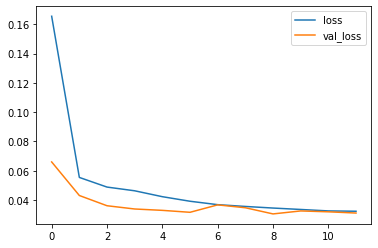

loss =  0.03227931633591652 , val_loss =  0.031052395701408386
 현 회차 : kjfk
246/246 [==============================] - 52s 211ms/step - loss: 0.0323 - mae: 0.0665 - val_loss: 0.0311 - val_mae: 0.0622
Epoch 13/30
 98/246 [==========>...................] - ETA: 29s - loss: 0.0317 - mae: 0.0647

KeyboardInterrupt: ignored

In [ ]:
#해당 airport 요소들 
models_list = {}
historys_list = {}
for airport in airport_names:
  airport_config = config_df[airport]
  shape = len(airport_config.columns[2:])
  tiomestamps = make_timestamps(airport_config)

  #train-valid  분할 
  train_timestamps = timestamps[:15738]
  valid_timestamps = timestamps[15750:]

  #제너레이터
  BATCH_SIZE = 64
  train_generator = DataGenerator(airport_config,train_timestamps,BATCH_SIZE)
  valid_generator = DataGenerator(airport_config,valid_timestamps,BATCH_SIZE)

  #모델
  config_input = Input((12,shape))
  model = make_model(config_input)

  model.compile(optimizer='adam',loss = 'mse',metrics=['mae'])
  history = model.fit(train_generator,validation_data = valid_generator, epochs=30,verbose=1,callbacks=callbacks)
  
  models_list[airport] = model
  historys_list[airport] = history
  

# Submission 

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/데이터보관/공유용/open_submission_format (1).csv')

In [ ]:
airport = 'kjfk'
#submission 파일에서 해당 공항 timestamps만 추출 
test_timestamps = list(np.unique(submission.loc[submission['airport']==airport,'timestamp']))
#추출한 timestamps로 제너레이터 만듬
test_generator = DataGenerator(config_df[airport],test_timestamps,BATCH_SIZE)
#위에서 만든 모델로 regression 
y_ = model.predict(test_generator)

In [ ]:
#regression 결과를 0~1 사이의 값, sum ==1 로 만들어 줌 ---> rescaling 
for j in tqdm(range(len(y_))):
  predicted = y_[j]
  total = np.sum(predicted,axis=1)
  for i in range(12):
    predicted[i] = predicted[i]/total[i]
  y_[j] = predicted

100%|██████████| 810/810 [00:00<00:00, 27810.95it/s]


In [ ]:
y_ = y_.reshape(len(test_timestamps),-1)

810

In [ ]:
#위에서 rescaling된 값을 submission 파일에 넣어 줌 
for time_num, time in tqdm(enumerate(test_timestamps)):
    submission.loc[(submission['airport']==airport) & (submission['timestamp']==time),'active'] = y_[time_num]

810it [03:45,  3.59it/s]
